# Unified MDTF/GFDL/NCAR Analysis Notebook Template

More details on the development process:
[MDTF Planning Document](https://docs.google.com/document/d/1P8HqL8O5304qwR3ik9RmgFDwSWwlkPgOjnp39PIkLfY/edit?usp=sharing)

In [2]:
# Development mode: constantly refreshes module code
%load_ext autoreload
%autoreload 2

## Framework Code and Diagnostic Setup

In [3]:
from esnb import NotebookDiagnostic, RequestedVariable, CaseGroup

Matplotlib is building the font cache; this may take a moment.


In [13]:
%%time

# Define a mode (leave "prod" for now)
mode = "prod"

# Verbosity
verbose = True

# Give your diagnostic a name and a short description
diag_name = "Example Notebook-based Diagnostic"
diag_desc = "This example demonstrates how to use the notebook template"

# Define what variables you would like to analyze. The first entry is the
# variable name and the second entry is the realm (post-processing dir).
#   (By default, monthly timeseries data will be loaded. TODO: add documentation
#    on how to select different frequencies, multiple realms to search, etc.)
variables = [
    RequestedVariable("rsughg", "atmos_level_cmip"),
    RequestedVariable("rlughg", "atmos_level_cmip"),
    RequestedVariable("rsdghg", "atmos_level_cmip"),
    RequestedVariable("rldghg", "atmos_level_cmip"),
    RequestedVariable("rsu", "atmos_level_cmip"),
    RequestedVariable("rlu", "atmos_level_cmip"),
    RequestedVariable("rsd", "atmos_level_cmip"),
    RequestedVariable("rld", "atmos_level_cmip"),
]

# Initialize the diagnostic with its name, description, vars, and options
diag = NotebookDiagnostic(diag_name, diag_desc, variables=variables)

# Define the groups of experiments to analyze. Provide a single dora id for one experiment
# or a list of IDs to aggregate multiple experiments into one; e.g. historical+future runs
# dora id: cm5-9
groups = [
    CaseGroup("am5dt-377", date_range=("0001-01-01", "0095-12-31"), verbose=verbose)
]

# Combine the experiments with the diag request and determine what files need to be loaded:
diag.resolve(groups)

am5dt-377: Fetching metadata from Dora
am5dt-377: Loading intake catalog from Dora
Resolving required vars for c96L65_am5f8d6r2_OM4_p25_piControl_noBLING_DynVeg
CPU times: user 6.01 s, sys: 102 ms, total: 6.11 s
Wall time: 7.67 s


<i>(The files above are necessary to run the diagnostic.)</i>

In [14]:


# Load the data as xarray datasets
diag.load()

# Put all of the xarray datasets into a list
dsets = diag.dsets

In [15]:
itrop = 41
itop = 65
for group in groups:
    group.ds[0]['lwtrop'] = group.ds[0]['rlu'][:,itrop,:,:] - group.ds[0]['rld'][:,itrop,:,:]
    group.ds[0]['swtrop'] = group.ds[0]['rsu'][:,itrop,:,:] - group.ds[0]['rsd'][:,itrop,:,:]
    group.ds[0]['lwtrop_ghg'] = group.ds[0]['rlughg'][:,itrop,:,:] - group.ds[0]['rldghg'][:,itrop,:,:]
    group.ds[0]['swtrop_ghg'] = group.ds[0]['rsughg'][:,itrop,:,:] - group.ds[0]['rsd'][:,itrop,:,:]
    group.ds[0]['lwtoa'] = group.ds[0]['rlu'][:,itop,:,:] 
    group.ds[0]['swtoa'] = group.ds[0]['rsu'][:,itop,:,:] 
    group.ds[0]['lwtoa_ghg'] = group.ds[0]['rlughg'][:,itop,:,:] 
    group.ds[0]['swtoa_ghg'] = group.ds[0]['rsughg'][:,itop,:,:] 
    group.ds[0]['lwtoa_forcing'] = -group.ds[0]['lwtoa_ghg'] + group.ds[0]['lwtoa'] 
    group.ds[0]['swtoa_forcing'] = -group.ds[0]['swtoa_ghg'] + group.ds[0]['swtoa'] 
    group.ds[0]['lwtrop_forcing'] = -group.ds[0]['lwtrop_ghg'] + group.ds[0]['lwtrop'] 
    group.ds[0]['swtrop_forcing'] = -group.ds[0]['swtrop_ghg'] + group.ds[0]['swtrop'] 
    group.ds[0]['nettrop_forcing'] = group.ds[0]['lwtrop_forcing'] + group.ds[0]['swtrop_forcing'] 
    group.ds[0]['nettoa_forcing'] = group.ds[0]['swtoa_forcing'] + group.ds[0]['lwtoa_forcing']


In [16]:
import os

import cftime
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr


Processing lwtrop_forcing


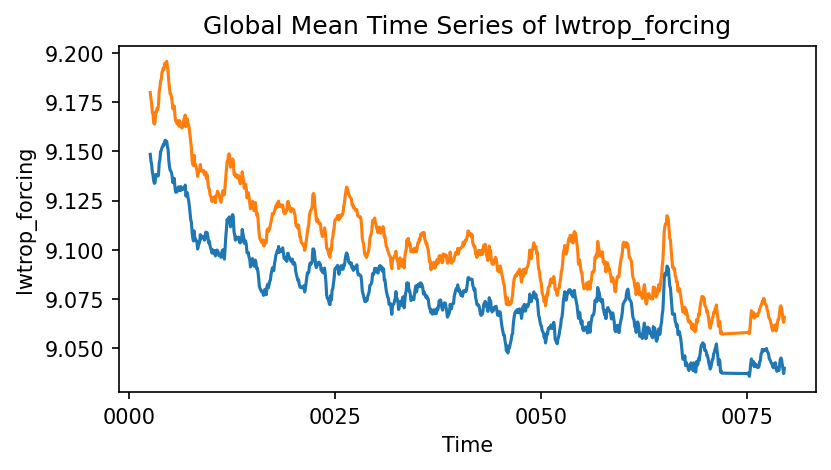

In [17]:
for group in groups:
    fig = plt.figure(figsize=(6, 3), dpi=150)
    plot_variable = {'lwtoa','lwtrop_forcing','nettrop_forcing'}
    ds = group.ds[0]
    weights = np.cos(np.deg2rad(ds['lat']))
    weights.name = "weights"
    ax = plt.subplot(1, 1, 1)

    var = 'lwtrop_forcing'
    print(f"Processing {var}")
        
    # Trigger computation explicitly before plotting
    timeseries = ds[var].weighted(weights).mean(dim=['lat', 'lon']).compute().rolling(time=12, center=True).mean()-0.33

    ax.plot(ds.time, timeseries)
    ax.set_title(f'Global Mean Time Series of {var}')
    ax.set_xlabel('Time')
    ax.set_ylabel(var)

    timeseries = 0.0511*(ds['lwtoa'].weighted(weights).mean(dim=['lat', 'lon']).compute().rolling(time=12, center=True).mean() - 63)
    ax.plot(ds.time, timeseries)
    


In [18]:
    plt.tight_layout()
    ax.legend()
    plt.show()

/vftmp/Jing.Feng/pid3285222/ipykernel_3309842/3159932216.py:2: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


<Figure size 640x480 with 0 Axes>